In [1]:
import torch
torch.__version__

/home/think/anaconda3/lib/python3.7/site-packages/numpy/__init__.py:140: UserWarning: mkl-service package failed to import, therefore Intel(R) MKL initialization ensuring its correct out-of-the box operation under condition when Gnu OpenMP had already been loaded by Python process is not assured. Please install mkl-service package, see http://github.com/IntelPython/mkl-service
  from . import _distributor_init


'1.7.1'

In [2]:
import os
import re

import cv2
import numpy as np
# import torch
from skimage import io
from torch import nn
from torchvision import models
import matplotlib.pyplot as plt

In [3]:
import os
import warnings

import mmcv
import torch
from mmcv import Config, DictAction
from mmcv.cnn import fuse_conv_bn
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmcv.runner import (get_dist_info, init_dist, load_checkpoint,
                         wrap_fp16_model)

from mmdet.apis import multi_gpu_test, single_gpu_test
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector

In [4]:
cfg = Config.fromfile('work_dirs/faster_rcnn_r101_fpn_48e_coco_data1000_0228/faster_rcnn_r101_fpn_48e_coco_data1000_0228.py')

In [5]:
model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg'))

2021-03-23 17:31:23,554 - mmdet - INFO - load model from: torchvision://resnet101
2021-03-23 17:31:23,759 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias



In [6]:
checkpoint = load_checkpoint(model, 'work_dirs/faster_rcnn_r101_fpn_48e_coco_data1000_0228/epoch_48.pth', map_location='cpu')

In [7]:
model.CLASSES = checkpoint['meta']['CLASSES']

In [8]:
model.CLASSES = checkpoint['meta']['CLASSES']

FasterRCNN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [53]:
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
    dataset,
    samples_per_gpu=1,
    workers_per_gpu=cfg.data.workers_per_gpu,
    dist=False,
    shuffle=False)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [54]:
data = []
for i, t in enumerate(data_loader):
    tmp = {}
    tmp['img'] = t['img']
    tmp['img_metas'] = t['img_metas'][0].data[0]
    data.append(tmp)

In [26]:
################################################
data[1]

{'img': [tensor([[[[-0.7308, -0.7308, -0.7479,  ...,  1.2899,  1.2899,  1.2899],
            [-0.7308, -0.7479, -0.7479,  ...,  1.2899,  1.2899,  1.2899],
            [-0.7308, -0.7308, -0.7479,  ...,  1.2728,  1.2899,  1.2899],
            ...,
            [-0.6794, -0.6452, -0.5938,  ...,  0.9303,  0.9646,  0.9817],
            [-0.6452, -0.6281, -0.5938,  ...,  0.9303,  0.9646,  0.9817],
            [-0.6281, -0.6109, -0.5938,  ...,  0.9303,  0.9646,  0.9988]],
  
           [[-0.1450, -0.1625, -0.1625,  ...,  1.4657,  1.4657,  1.4657],
            [-0.1450, -0.1625, -0.1625,  ...,  1.4657,  1.4657,  1.4657],
            [-0.1450, -0.1450, -0.1625,  ...,  1.4482,  1.4657,  1.4657],
            ...,
            [-0.2150, -0.1800, -0.1450,  ...,  1.0805,  1.0980,  1.1155],
            [-0.1975, -0.1800, -0.1450,  ...,  1.0630,  1.0980,  1.1331],
            [-0.1975, -0.1800, -0.1625,  ...,  1.0805,  1.1155,  1.1331]],
  
           [[-0.4624, -0.4798, -0.4798,  ...,  1.5768,  1.5768,

In [11]:

# cfg.nms_pre = 1000
# cfg.min_bbox_size = 1
# cfg.nms_thr = 10
# cfg.nms_post = 1000
test_cfg = model.rpn_head.test_cfg

# img_metas = data['img_metas']
####################################################################################3
# 此處重寫了rpn_head.get_bboxes，因爲原函數使用detach把gradients的backprop刪了無法backward（）
#######################################################################################

def get_bboxes_tmp(rpn_outs, img_metas, test_cfg):
    
    with_nms = False
    rescale = False
    cls_scores = rpn_outs[0]
    bbox_preds = rpn_outs[1]

    num_levels = len(cls_scores)

    device = cls_scores[0].device
    featmap_sizes = [cls_scores[i].shape[-2:] for i in range(num_levels)]
    mlvl_anchors = model.rpn_head.anchor_generator.grid_anchors(
        featmap_sizes, device=device)

    result_list = []
    for img_id in range(len(img_metas)):
        cls_score_list = [
            cls_scores[i][img_id] for i in range(num_levels) # 此處不再使用detach()
        ]
        bbox_pred_list = [
            bbox_preds[i][img_id] for i in range(num_levels) # 此處不再使用detach()
        ]
        img_shape = img_metas[img_id]['img_shape']
        scale_factor = img_metas[img_id]['scale_factor']

        if with_nms:
            # some heads don't support with_nms argument
            proposals = model.rpn_head._get_bboxes_single(cls_score_list,
                                                bbox_pred_list,
                                                mlvl_anchors, img_shape,
                                                scale_factor, test_cfg, rescale)
        else:
            proposals = model.rpn_head._get_bboxes_single(cls_score_list,
                                                bbox_pred_list,
                                                mlvl_anchors, img_shape,
                                                scale_factor, test_cfg, rescale)
        result_list.append(proposals)
    
    return result_list

In [26]:
###########################################################
for name, m in model.named_modules():
        if isinstance(m, nn.Conv2d):
            print(name,',',m)

backbone.conv1 , Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
backbone.layer1.0.conv1 , Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
backbone.layer1.0.conv2 , Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
backbone.layer1.0.conv3 , Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
backbone.layer1.0.downsample.0 , Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
backbone.layer1.1.conv1 , Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
backbone.layer1.1.conv2 , Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
backbone.layer1.1.conv3 , Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
backbone.layer1.2.conv1 , Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
backbone.layer1.2.conv2 , Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
backbone.layer1.2.conv3 , Conv2d(64, 256, kernel_size=

In [12]:
class GradCAM(object):
    """
    1: 网络不更新梯度,输入需要梯度更新
    2: 使用目标类别的得分做反向传播
    """

    def __init__(self, net, layer_name):
        self.net = net
        self.layer_name = layer_name
        self.feature = None
        self.gradient = None
        self.net.eval()
        self.handlers = []
        self._register_hook()

    def _get_features_hook(self, module, input, output):
        self.feature = output
        # print("feature shape:{}".format(output.size()))

    def _get_grads_hook(self, module, input_grad, output_grad):
        """

        :param input_grad: tuple, input_grad[0]: None
                                   input_grad[1]: weight
                                   input_grad[2]: bias
        :param output_grad:tuple,长度为1
        :return:
        """
        self.gradient = output_grad[0]
        # print('gradient:', self.gradient)

    def _register_hook(self):
        for (name, module) in self.net.named_modules():
            if name == self.layer_name:
                self.handlers.append(module.register_forward_hook(self._get_features_hook))
                self.handlers.append(module.register_backward_hook(self._get_grads_hook))
#         module = self.net.rpn.head.bbox_pred
#         self.handlers.append(module.register_forward_hook(self._get_features_hook))
#         self.handlers.append(module.register_backward_hook(self._get_grads_hook))
            
                # print(self.handlers)

    def remove_handlers(self):
        for handle in self.handlers:
            handle.remove()

    def __call__(self, inputs, index=0):
        """

        :param inputs: {"image": [C,H,W], "height": height, "width": width}
        :param index: 第几个边框
        :return:
        """
        self.net.zero_grad()
        # output = self.net([inputs])
        x = self.net.extract_feat(inputs['img'][0])
        rpn_outs = self.net.rpn_head(x)
        result_list = get_bboxes_tmp(rpn_outs,inputs['img_metas'],self.net.rpn_head.test_cfg)
        res= self.net.roi_head.simple_test_bboxes(
            x, inputs['img_metas'], result_list, self.net.roi_head.test_cfg, rescale=True)
        # print(output)
        score = res[0][0][index][4]
        # proposal_idx = output[0]['labels'][index]  # box来自第几个proposal
        # print(score)
        score.backward()
        # print('gradient:', self.gradient)

        # gradient = self.gradient[proposal_idx].cpu().data.numpy()  # [C,H,W]
        gradient = self.gradient.cpu().data.numpy().squeeze()
        
        weight = np.mean(gradient, axis=(1, 2))  # [C]

        # feature = self.feature[proposal_idx].cpu().data.numpy()  # [C,H,W]
        feature = self.feature.cpu().data.numpy().squeeze()

        cam = feature * weight[:, np.newaxis, np.newaxis]  # [C,H,W]
        # print(cam.shape)
        cam = np.sum(cam, axis=0)  # [H,W]
        cam = np.maximum(cam, 0)  # ReLU

        # 数值归一化
        cam -= np.min(cam)
        cam /= np.max(cam)
        # resize to 224*224
        # box = output[0]['instances'].pred_boxes.tensor[index].detach().numpy().astype(np.int32)
        box = res[0][0][index][:-1].detach().numpy().astype(np.int32)
        x1, y1, x2, y2 = box
        
        # cam = cv2.resize(cam, (x2 - x1, y2 - y1))
        # cam = cv2.resize(cam, (y2 - y1, x2 - x1)).T
        # print(cam.shape)

        # class_id = output[0]['instances'].pred_classes[index].detach().numpy()
        class_id = res[1][0][index].detach().numpy()
        plt.imshow(cam)
        return cam, box, class_id

In [40]:
grad_cam = GradCAM(model, 'backbone.layer4.2.conv1')

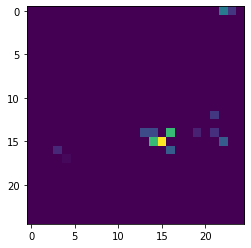

In [56]:
mask, box, class_id = grad_cam(data[0],0)

In [15]:
def norm_image(image):
    """
    标准化图像
    :param image: [H,W,C]
    :return:
    """
    image = image.copy()
    image -= np.max(np.min(image), 0)
    image /= np.max(image)
    image *= 255.
    return np.uint8(image)

def gen_cam(image, mask):
    """
    生成CAM图
    :param image: [H,W,C],原始图像
    :param mask: [H,W],范围0~1
    :return: tuple(cam,heatmap)
    """
    # mask转为heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = heatmap[..., ::-1]  # gbr to rgb

    # 合并heatmap到原始图像
    cam = heatmap + np.float32(image)
    return norm_image(cam), heatmap

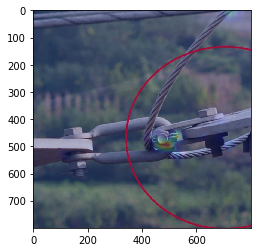

In [57]:
image_dict = {}
im = data[0]['img'][0].squeeze(0).permute(1,2,0)
mask = cv2.resize(mask, (im.shape[1], im.shape[0]))
image_cam, image_dict['heatmap'] = gen_cam(im, mask)
plt.imshow(image_cam)